# Python multiprocessing and hierarchical data

In this exercise we will adapt the [epidemic model from last time](http://marcc-hpc.github.io/esc/notebooks/epidemic/epidemic.html) for execution *in a single python process*. In contrast to the parallelism we discussed last time (thanks to either SLURM or GNU parallel), this method offers the opportunity to save all of the data to a single file. We will use the [h5py](https://www.h5py.org/) library to do this. The work pattern in this example is generally useful to researchers who wish to write codes which can use an entire compute node and efficiently write the results in one place.

### Requirements

We are using the following requrements file for an Anaconda environment.

~~~
dependencies:
  - python=3.7
  - matplotlib
  - scipy
  - numpy
  - nb_conda_kernels
  - au-eoed::gnu-parallel
  - h5py
  - pip
~~~

Recall that you can review the [instructions for creating an environment](https://marcc-hpc.github.io/esc/common/python-environments#conda).

In [1]:
import os,sys
import h5py
import json
import time
import functools
import numpy as np
import multiprocessing as mp

## Define a simple numerical experiment

The following code was rescued from [last time](http://marcc-hpc.github.io/esc/notebooks/epidemic/epidemic.html), thanks to [a course by Chris Meyers](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/SIR/SIR.html).

In [2]:
class StochasticSIR:

    def __init__(self,beta,gamma,S,I,R):
        self.S = S
        self.I = I
        self.R = R
        self.beta = beta
        self.gamma = gamma
        self.t = 0.
        self.N = S + I + R
        self.trajectory = np.array([[self.S, self.I, self.R]])
        self.times = None

    def step(self):
        transition = None
        # define rates
        didt = self.beta * self.S * self.I
        drdt = self.gamma * self.I
        total_rate = didt + drdt
        if total_rate == 0.:
            return transition, self.t
        # get a random number
        rand = np.random.random()
        # rates determine the event
        if rand < didt/drdt:
            self.S -= 1
            self.I += 1
            transition = 1
        else:
            self.I -= 1
            self.R += 1
            transition = 2
        # the event happens in the future
        dt = np.random.exponential(1./total_rate,1)[0]
        self.t += dt
        return transition, self.t

    def run(self, T=None, make_traj=True):
        """The Gillespie algorithm."""
        if T is None:
            T = sys.maxsize
        self.times = [0.]
        t0 = self.t
        transition = 1
        while self.t < t0 + T:
            transition, t = self.step()
            if not transition:
                return self.t
            if make_traj: self.trajectory = np.concatenate(
                (self.trajectory, [[self.S,self.I,self.R]]), axis=0)
            self.times.append(self.t)
        return

We slightly modify the `study_beta` function so that it also returns a list of the parameters. We will use these later to keep track of our experiments.

In [3]:
def study_beta(
    beta = .005,gamma = 10,
    N = 100,I = 1,n_expts = 1000):
    """
    Run many experiments for a particular beta 
    to see how many infections spread.
    """
    R = 0
    S = N-I
    result = np.zeros((n_expts,))
    for expt_num in range(len(result)):
        model = StochasticSIR(beta=beta,gamma=gamma,S=S,I=I,R=R)
        model.run()
        result[expt_num] = model.trajectory[-1][2]
    params = dict(beta=beta,gamma=gamma,N=N,I=I,n_expts=n_expts)
    return result,params

In [4]:
# generate some example data
result,params = study_beta()

In [5]:
# we delete the example output files during testing
# h5py will not overwrite files and must always close a file when finished
! rm -f example.hdf5

In the following example, we will save only the resulting data using `h5py` and then read it back in. We find that the `hdf5` objects are represented slightly differently than `numpy` objects, but we can recast them easily.

In [6]:
result,params = study_beta()
fn = 'example.hdf5'
if not os.path.isfile(fn):
    fobj = h5py.File(fn,'w')
    fobj.create_dataset('result',data=result)
    fobj.close()
else: raise Exception('file exists: %s'%fn)

In [7]:
# read the result
with h5py.File(fn,'r') as fp:
    print(fp)
    for key in fp:
        print('found key: %s'%key)
        # the file object acts like a dict
        print(fp[key])
        # recast as an array
        print(np.array(fp[key])[:10])

<HDF5 file "example.hdf5" (mode r)>
found key: result
<HDF5 dataset "result": shape (1000,), type "<f8">
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Now that we have established that we can write different datasets to a single file, we can build our multiprocessing script.

### Aside: large parameter sweeps

In this example we will only recapitulate a one-parameter sweep from last time. Many experiments require a much larger search. After we complete a minimum working example (MWE), you may wish to use the following code to expand our one-parameter sweep to two parameters. It's important to keep in mind that the utility of this would be limited for the SIR model as we have written it, since that model benefits from using the *basic reproduction number* instead.

In [8]:
import itertools
beta_sweep = np.arange(0.001,0.02,0.001)
gamma_sweep = 1./np.arange(1.0,10+1)
combos = itertools.product(beta_sweep,gamma_sweep)

## A minimal multiprocessing example

First we define a simple parameter sweep.

In [9]:
n_expts = 1000
r0_vals = np.arange(0.1,5,0.1)
gamma = 10.0
beta_sweep = r0_vals/gamma
beta_sweep

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49])

In [10]:
# check the number of processors
print("we have %d processors"%mp.cpu_count())

we have 8 processors


The following code includes an MWE for using a multiprocessing pool along with a hierarchical data file. It contains several notable features:

- We remove the output file during testing.
- We check to make sure the file does not exist already (`h5py` will not let you overwrite it).
- We manipulate files inside of a `with` block to ensure they are closed correctly.
- We tested the serial method alongside the parallel one. The asynchronous parallel operations would "fail silently" which made them very hard to debug!
- We use a "blocking" callback to write the results.
- The function that writes the data is "decorated" so that it can receive the file pointer.

We will discuss this example further in class. The first order of business is to make sure it goes faster in parallel.

In [11]:
! rm -f out.hdf5

if os.path.isfile('out.hdf5'):
    raise Exception('file exists!')

do_parallel = False

def writer(incoming,fp=None):
    print('.',end='')
    result,params = incoming
    index = len(fp.attrs)
    dset = fp.create_dataset(str(index),data=result)
    fp.attrs[str(index)] = np.string_(json.dumps(params))

start_time = time.time()
if do_parallel:
    with h5py.File('out.hdf5','w') as fp:
        def handle_output(x): return writer(x,fp=fp)
        pool = mp.Pool(mp.cpu_count())
        for beta in beta_sweep:
            pool.apply_async(
                functools.partial(study_beta,gamma=gamma),
                (beta,),
                callback=handle_output)
        pool.close()
        pool.join()
        fp.close()
else:
    # develop in serial to catch silent async errors
    with h5py.File('out.hdf5','w') as fp:
        for index,beta in enumerate(beta_sweep):
            print('.',end='')
            output = study_beta(beta=beta,n_expts=n_expts,gamma=gamma)
            writer(output,fp=fp)
# compare the parallel time to the serial time (~35s)
print('time: %.1fs'%(time.time()-start_time))

..................................................................................................time: 94.9s


Now that we have a useful parallel code, we can analyze the data.

In [12]:
# unpack the data
meta,data = [],[]
with h5py.File('out.hdf5','r') as fp:
    for index,key in enumerate(fp):
        meta.append(json.loads(fp.attrs[key]))
        data.append(np.array(fp[key]))
# look at the data
for index,(m,d) in enumerate(zip(meta,data)):
    print("Experiment %d"%index)
    print("Metadata: %s"%str(m))
    print("Result: %s"%str(d.mean()))
    # we got the idea so break
    if index>2: break
    #
# reformulate the relevant values
epidemic_rate = []
afflicted = []
for index,(m,d) in enumerate(zip(meta,data)):
    epidemic_rate.append((m['beta']*gamma,np.mean(d>1)))
    afflicted.append((m['beta']*gamma,np.mean(d)))
# sort it, since it comes out all jumbled (but why?)
epidemic_rate = sorted(epidemic_rate,key=lambda x:x[0])
afflicted = sorted(afflicted,key=lambda x:x[0])

Experiment 0
Metadata: {'beta': 0.01, 'gamma': 10.0, 'N': 100, 'I': 1, 'n_expts': 1000}
Result: 1.122
Experiment 1
Metadata: {'beta': 0.02, 'gamma': 10.0, 'N': 100, 'I': 1, 'n_expts': 1000}
Result: 1.31
Experiment 2
Metadata: {'beta': 0.11000000000000001, 'gamma': 10.0, 'N': 100, 'I': 1, 'n_expts': 1000}
Result: 83.872
Experiment 3
Metadata: {'beta': 0.12000000000000002, 'gamma': 10.0, 'N': 100, 'I': 1, 'n_expts': 1000}
Result: 87.219


In [13]:
# imports for plotting
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

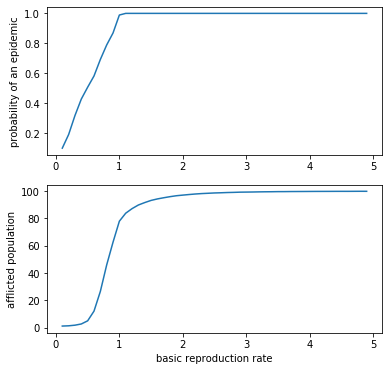

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(211)
ax.plot(*zip(*epidemic_rate))
ax.set_ylabel('probability of an epidemic')
ax = fig.add_subplot(212)
ax.plot(*zip(*afflicted))
ax.set_ylabel('afflicted population')
ax.set_xlabel('basic reproduction rate')
plt.show()

This concludes the exercise. Interested readers are welcome to expand the example above so that it performs a sweep over more than one parameter.